In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import date
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA

/Users/KenLu/anaconda/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
SEED = 1990
N_DAYS = 954
N_CLUSTERS = 5
N_COMPONENTS = 29
# TIMESERIES_SZ = 300
N_TEST_DATA = 400
VAR_PERCENTILE_LEVEL = 5
METRIC = "dtw"
# METRIC = "euclidean"
FONT = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

In [3]:
connection = pg.connect(database="postgres", user="postgres", password="Crypto01", host="localhost", port=5430)
cur = connection.cursor()

In [4]:
cur.execute("SELECT * FROM input.stock_daily_changes ORDER BY date DESC LIMIT %s" % str(N_DAYS))
data = sorted(cur.fetchall(), key=lambda row: row[0], reverse=False)
daily_changes = pd.DataFrame(data=data, columns=[desc[0] for desc in cur.description], index=[row[0] for row in data], dtype="float64")
daily_changes = daily_changes.drop(["date"], axis=1)
daily_changes = daily_changes[daily_changes.index <= date(2018, 7, 31)]
daily_changes = daily_changes - 1
transpose_df = daily_changes.transpose()

<Figure size 432x288 with 0 Axes>

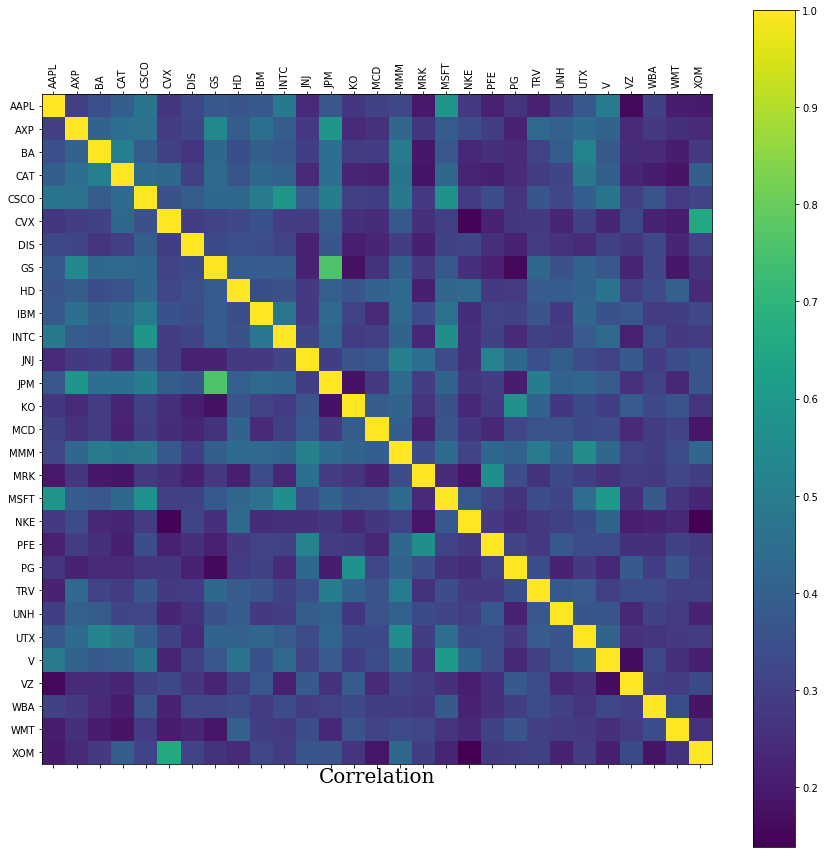

In [5]:
corr_mat = daily_changes.corr()
cryptos = np.array(corr_mat.columns)
plt.clf()
plt.rcParams['figure.figsize'] = [20, 15]
plt.matshow(corr_mat)
plt.xticks(range(len(cryptos)), cryptos, rotation="vertical")
plt.yticks(range(len(cryptos)), cryptos)
plt.xlabel("Correlation", fontdict=FONT)
plt.colorbar()
plt.show()

In [6]:
training_data = np.array(transpose_df)
# training_data = TimeSeriesResampler(sz=TIMESERIES_SZ).fit_transform(training_data)
# training_data = normalize(training_data, norm="l2")
pca = PCA(n_components=N_COMPONENTS)
training_data = pca.fit_transform(training_data)
dba_km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, max_iter=100, metric=METRIC, verbose=True, max_iter_barycenter=10, random_state=SEED)
pred_clusters = dba_km.fit_predict(training_data)

0.017 --> 0.013 --> 0.013 --> 0.013 --> 0.013 --> 


In [7]:
print("Percentage of interpretation:", sum(pca.explained_variance_ratio_))

Percentage of interpretation: 1.0


In [8]:
training_clusterList = {}
training_varList = {}
test_clusterList = {}
test_varList = {}

In [9]:
training_list = transpose_df.iloc[:, N_TEST_DATA:]
training_var = [np.percentile(row, VAR_PERCENTILE_LEVEL) for row in np.array(training_list)]
test_list = transpose_df.iloc[:, :N_TEST_DATA]

for i in set(pred_clusters):
    training_clusterList[i] = transpose_df.iloc[np.where(pred_clusters == i)[0], N_TEST_DATA:]
    training_varList[i] = np.percentile(np.array(training_clusterList[i]).ravel(), VAR_PERCENTILE_LEVEL)
    test_clusterList[i] = transpose_df.iloc[np.where(pred_clusters == i)[0], :N_TEST_DATA]
    test_varList[i] = np.percentile(np.array(test_clusterList[i]).ravel(), VAR_PERCENTILE_LEVEL)
    
before = np.array([len(row[row < training_var[i]])/N_TEST_DATA for i, row in enumerate(np.array(test_list))])
after = []

for i in set(pred_clusters):
    after.append([(len(crypto) - len(crypto[np.where(np.isnan(crypto))]))/len(crypto) for crypto in np.array(test_clusterList[i][test_clusterList[i] < training_varList[i]])])
   
after = np.hstack(after)

print("Before :", len(before[before < VAR_PERCENTILE_LEVEL/100])/len(before))
print("After :", len(after[np.where(after < VAR_PERCENTILE_LEVEL/100)])/len(after))

Before : 0.896551724137931
After : 1.0


In [10]:
training_before = np.array([len(row[row < training_var[i]])/(N_DAYS - N_TEST_DATA) for i, row in enumerate(np.array(training_list))])
training_after = []

for i in set(pred_clusters):
    training_after.append([(len(crypto) - len(crypto[np.where(np.isnan(crypto))]))/len(crypto) for crypto in np.array(training_clusterList[i][training_clusterList[i] < training_varList[i]])])
    
training_after = np.hstack(training_after)

In [11]:
len(training_before[training_before > 0.0501])/len(training_before)

0.0

In [12]:
len(training_after[training_after > 0.0501])/len(training_after)

0.6206896551724138

In [13]:
before[before > 0.05]

array([ 0.0725,  0.07  ])

In [14]:
after[after > 0.05]

array([], dtype=float64)

In [17]:
for cluster in set(pred_clusters):
    print("Cluster", cluster, ":", cryptos[np.where(pred_clusters == cluster)])

Cluster 0 : ['JNJ' 'MRK' 'PFE' 'PG' 'VZ' 'WMT']
Cluster 1 : ['GS' 'JPM']
Cluster 2 : ['AXP' 'BA' 'CAT' 'INTC' 'NKE' 'UTX' 'WBA']
Cluster 3 : ['AAPL' 'CSCO' 'CVX' 'HD' 'IBM' 'MSFT' 'V']
Cluster 4 : ['DIS' 'KO' 'MCD' 'MMM' 'TRV' 'UNH' 'XOM']


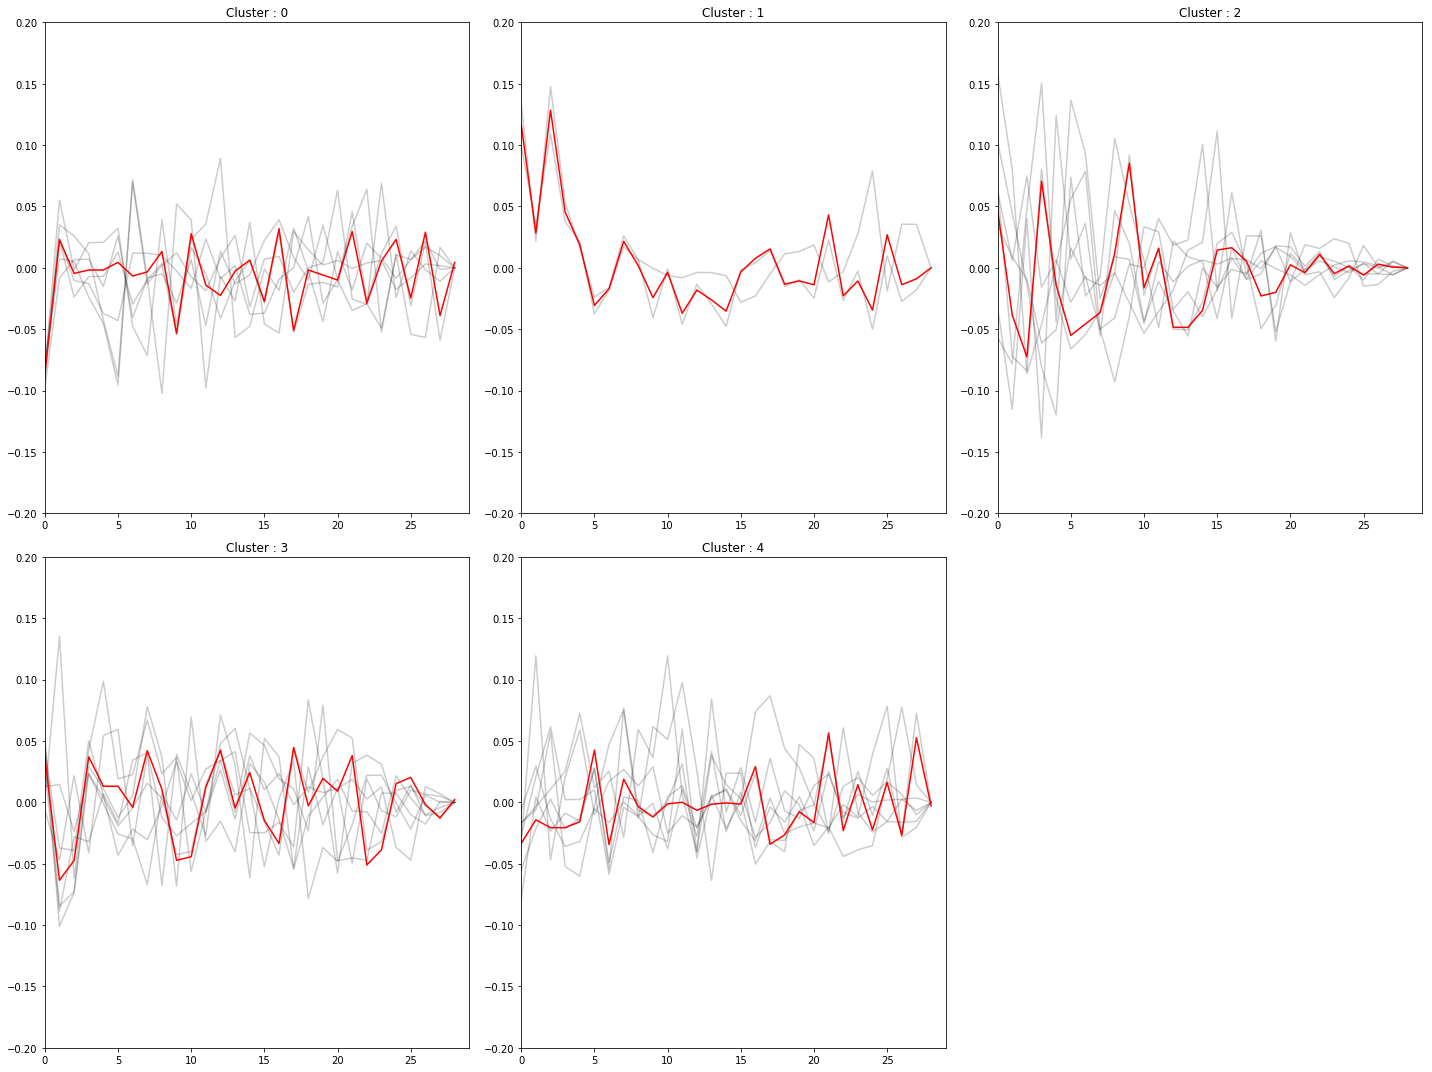

In [19]:
# Plot
plt.clf()
plt.rcParams['figure.figsize'] = [20, 15]
for yi in set(pred_clusters):
    plt.subplot(N_CLUSTERS/3 + 1, 3, yi + 1)
    for xx in training_data[pred_clusters == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, training_data.shape[1])
    plt.ylim(-0.2, 0.2)
    title = "Cluster : " + str(yi)
    plt.title(title)

plt.tight_layout()
plt.show()